In [32]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

class PeerToPeerDGD:
    def __init__(self, n_clients, p=0.5):
        """
        Initialize the DGD algorithm.

        Parameters:
        - n_clients: Number of clients
        - p: Connection probability for Erdős-Rényi graph
        """
        self.n_clients = n_clients
        
        # Generate network topology
        self.G = nx.erdos_renyi_graph(n_clients, p)
        
        # Calculate algebraic connectivity
        self.algebraic_connectivity = nx.algebraic_connectivity(self.G)
        
        # Randomly initialize target points for each client
        self.target_points = np.random.randn(n_clients, 2)
        
        # Initialize model parameters
        self.theta = np.zeros((n_clients, 2))
        
    def local_loss(self, theta, client_id):
        """
        Calculate the local loss for a single client.
        """
        return 0.5 * np.linalg.norm(theta - self.target_points[client_id])**2
    
    def global_loss(self, theta):
        """
        Calculate the global loss.
        """
        return np.mean([self.local_loss(theta, i) for i in range(self.n_clients)])
    
    def dgd_update(self, alpha=0.1, gamma=0.01, gradient_dissimilarity=0.1):
        """
        Perform a distributed gradient descent update.

        Parameters:
        - alpha: Gossip rate
        - gamma: Learning rate
        - gradient_dissimilarity: Level of gradient dissimilarity
        """
        # Store updated parameters
        new_theta = self.theta.copy()
        
        for i in range(self.n_clients):
            # Neighboring nodes
            neighbors = list(self.G.neighbors(i))
            
            # Gossip step: average parameters of neighboring nodes
            gossip_step = np.mean([self.theta[j] for j in neighbors], axis=0)
            theta_gossip = (1 - alpha) * self.theta[i] + alpha * gossip_step
            
            # Add noise for gradient dissimilarity
            noise = np.random.normal(0, gradient_dissimilarity, 2)
            
            # Gradient descent step
            gradient = theta_gossip - self.target_points[i] + noise
            new_theta[i] = theta_gossip - gamma * gradient
        
        self.theta = new_theta
        
    def run_experiment(self, n_iterations=100, alpha=0.1, gamma=0.01, gradient_dissimilarity=0.1):
        """
        Run the experiment and record losses over iterations.
        """
        losses = []
        for _ in range(n_iterations):
            loss = self.global_loss(np.mean(self.theta, axis=0))
            losses.append(loss)
            self.dgd_update(alpha, gamma, gradient_dissimilarity)
        
        return losses


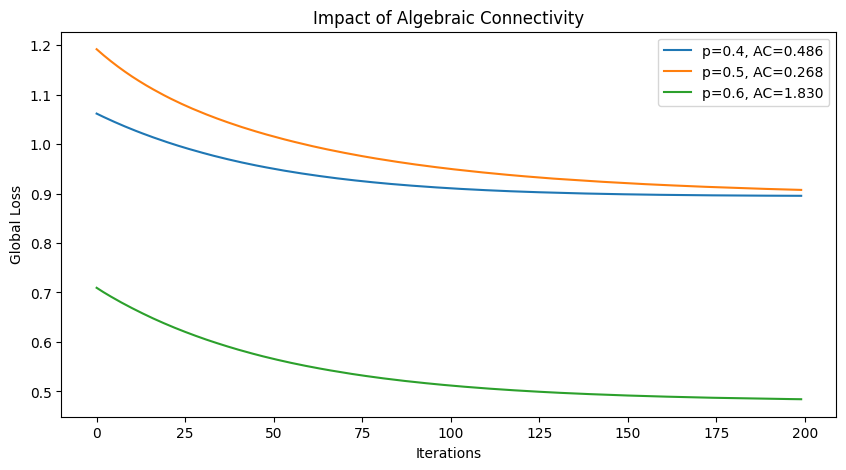

In [34]:
# Experiment 1: Investigating the effect of algebraic connectivity
def experiment_algebraic_connectivity():
    plt.figure(figsize=(10, 5))
    
    connection_probs = [0.4, 0.5, 0.6]
    
    for p in connection_probs:
        dgd = PeerToPeerDGD(n_clients=6, p=p)
        losses = dgd.run_experiment(
            n_iterations=200, 
            alpha=0.1, 
            gamma=0.01, 
            gradient_dissimilarity=0.01
        )
        plt.plot(losses, label=f'p={p}, AC={dgd.algebraic_connectivity:.3f}')
    
    plt.title('Impact of Algebraic Connectivity')
    plt.xlabel('Iterations')
    plt.ylabel('Global Loss')
    plt.legend()
    plt.show()

experiment_algebraic_connectivity()

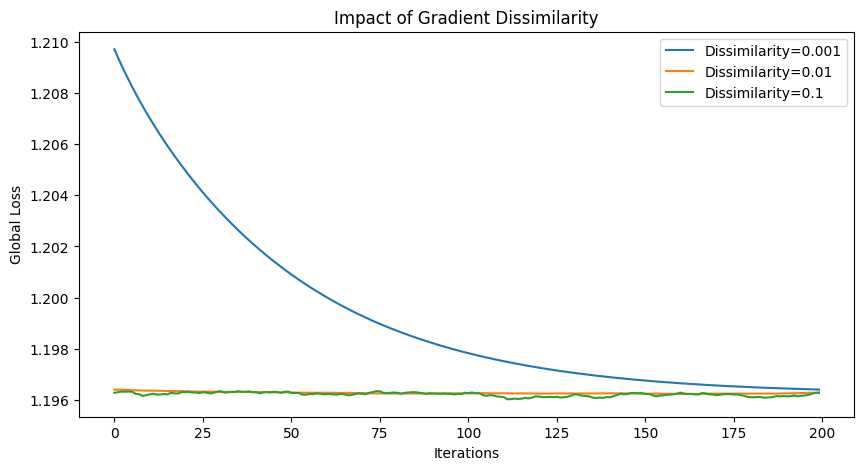

In [22]:
# Experiment 2: Investigating the effect of gradient dissimilarity
def experiment_gradient_dissimilarity():
    dgd = PeerToPeerDGD(n_clients=6)
    
    dissimilarity_levels = [0.001, 0.01, 0.1]
    plt.figure(figsize=(10, 5))
    
    for dissimilarity in dissimilarity_levels:
        losses = dgd.run_experiment(
            n_iterations=200, 
            alpha=0.1, 
            gamma=0.01, 
            gradient_dissimilarity=dissimilarity
        )
        plt.plot(losses, label=f'Dissimilarity={dissimilarity}')
    
    plt.title('Impact of Gradient Dissimilarity')
    plt.xlabel('Iterations')
    plt.ylabel('Global Loss')
    plt.legend()
    plt.show()

experiment_gradient_dissimilarity()